In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (v_measure_score, adjusted_rand_score, 
                            homogeneity_score, completeness_score,
                            silhouette_score, davies_bouldin_score,
                            calinski_harabasz_score)
from yellowbrick.cluster import KElbowVisualizer

colorss = ["#FF0054", "#00F5D4", "#FEE440", "#9B59B6"]

In [2]:
train_df = pd.read_csv('../../dataset/train.csv')
test_df = pd.read_csv('../../dataset/test.csv')
data = pd.concat([train_df, test_df])
# data = test_df


In [3]:
for col in data.columns[8:21]:
    value_counts = dict(data[col].value_counts())
    if 0 in value_counts:
        data = data[data[col] != 0]
    

    # Departure/Arrival time convenient, Ease of Online booking

In [4]:
data = data.drop(data.iloc[:, [0, 1]], axis=1) #Unnamed: 0, id, satisfaction
data = data[data['Class'] != 'Eco Plus']
data = data.drop(['Arrival Delay in Minutes'], axis=1)

In [5]:
object_cols = data.select_dtypes(include='object').columns
le = LabelEncoder()
for col in object_cols:
    data[col] = le.fit_transform(data[col])


In [6]:
# Align target with filtered data
target = data["satisfaction"].copy()
data = data.drop(data.iloc[:, [-1]], axis=1)


In [7]:
print(target.shape, data.shape)

(110788,) (110788, 21)


In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [9]:
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes
1,1,1,25,0,0,235,3,2,3,3,...,3,1,1,1,5,3,1,4,1,1
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,5,4,3,4,4,4,5,0
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,2,5,3,1,4,2,11
4,1,0,61,0,0,214,3,3,3,3,...,5,5,3,3,4,4,3,3,3,0
5,0,0,26,1,1,1180,3,4,2,1,...,2,1,1,3,4,4,4,4,1,0


In [10]:
pca = PCA(n_components=3, random_state=42)
pca.fit(data_scaled)
data_pca = pd.DataFrame(pca.transform(data_scaled), columns=(['col1', 'col2', 'col3']))
data_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,110788.0,-1.074908e-16,0.710195,-1.460223,-0.647940,0.024264,0.565712,1.884964
col2,110788.0,1.373779e-16,0.553324,-1.807907,-0.412093,0.006397,0.413420,1.643954
col3,110788.0,5.983828e-17,0.512740,-1.443082,-0.382405,-0.018027,0.378061,1.655697


In [11]:
print(data_pca.shape)
print(target.shape)

(110788, 3)
(110788,)


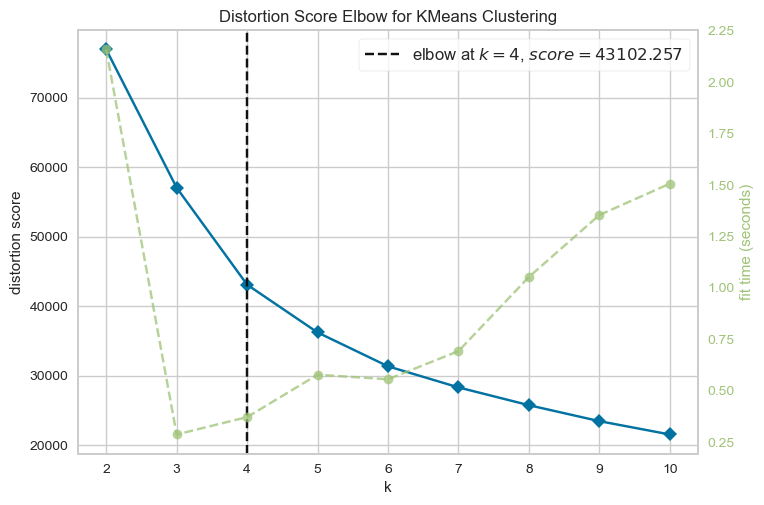

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
elbow = KElbowVisualizer(KMeans(n_init=10), k=10)
elbow.fit(data_pca)
elbow.show()

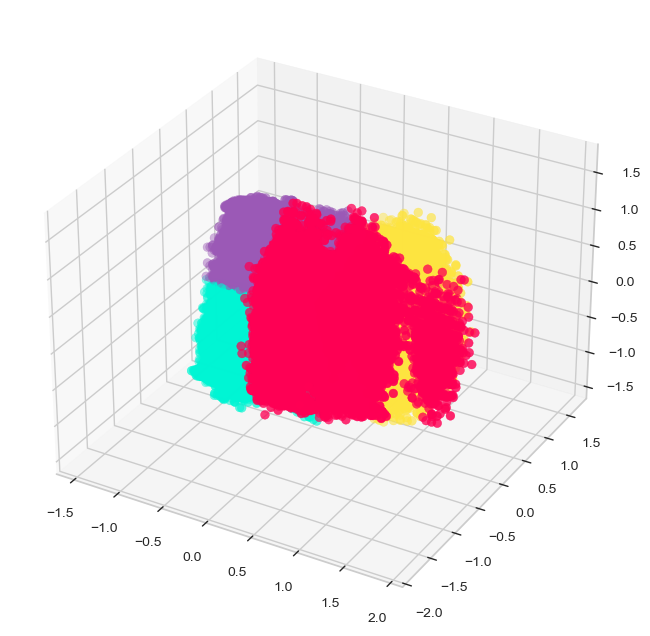

In [ ]:
data_scaled = pd.DataFrame(data_scaled, columns = data.columns)

# Use k = 4 from Elbow
model = KMeans(n_clusters=4, random_state=42, n_init=10)
predictions = model.fit_predict(data_pca)

data_pca['Cluster'] = predictions
data['Cluster'] = predictions
data_scaled['Cluster'] = predictions

#Plotting the clusters
x = data_pca['col1']
y = data_pca['col2']
z = data_pca['col3']
cmap = colors.ListedColormap(colorss)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=data_pca['Cluster'], marker='o', cmap = cmap)
plt.show()

V-Measure Score: 0.2688
  → Harmonic mean of homogeneity and completeness
  → Range: [0, 1], where 1 = perfect clustering

Homogeneity Score: 0.4046
  → Measures if each cluster contains only members of a single class
  → Range: [0, 1], where 1 = perfect homogeneity

Completeness Score: 0.2013
  → Measures if all members of a given class are in the same cluster
  → Range: [0, 1], where 1 = perfect completeness

Adjusted Rand Index (ARI): 0.2519
  → Measures similarity between clustering and ground truth
  → Range: [-1, 1], where 1 = perfect match, 0 = random, negative = worse than random


Summary of External Evaluation Metrics:
             Metric    Score                                Interpretation
          V-Measure 0.268840 Harmonic mean of homogeneity and completeness
        Homogeneity 0.404580          Each cluster contains only one class
       Completeness 0.201301        All members of a class in same cluster
Adjusted Rand Index 0.251889                Similarity adjusted

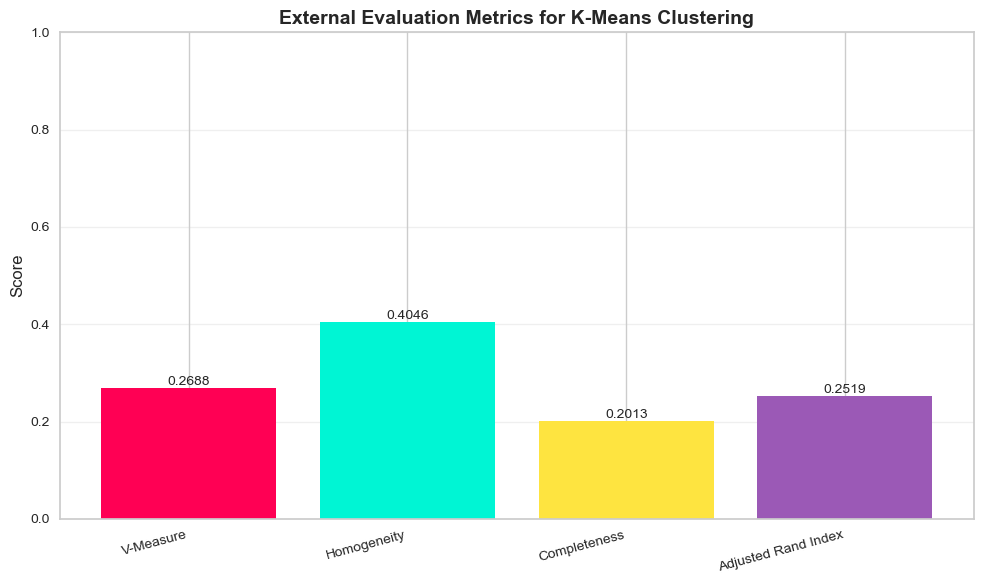

In [14]:
v_measure = v_measure_score(target, predictions)
print(f"V-Measure Score: {v_measure:.4f}")
print("  → Harmonic mean of homogeneity and completeness")
print("  → Range: [0, 1], where 1 = perfect clustering")
print()

# Homogeneity Score
# Measures if each cluster contains only members of a single class
homogeneity = homogeneity_score(target, predictions)
print(f"Homogeneity Score: {homogeneity:.4f}")
print("  → Measures if each cluster contains only members of a single class")
print("  → Range: [0, 1], where 1 = perfect homogeneity")
print()

# Completeness Score
# Measures if all members of a given class are assigned to the same cluster
completeness = completeness_score(target, predictions)
print(f"Completeness Score: {completeness:.4f}")
print("  → Measures if all members of a given class are in the same cluster")
print("  → Range: [0, 1], where 1 = perfect completeness")
print()

# Adjusted Rand Index (ARI)
# Measures similarity between two clusterings, adjusted for chance
ari = adjusted_rand_score(target, predictions)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print("  → Measures similarity between clustering and ground truth")
print("  → Range: [-1, 1], where 1 = perfect match, 0 = random, negative = worse than random")
print()

# Summary DataFrame
external_metrics = pd.DataFrame({
    'Metric': ['V-Measure', 'Homogeneity', 'Completeness', 'Adjusted Rand Index'],
    'Score': [v_measure, homogeneity, completeness, ari],
    'Interpretation': [
        'Harmonic mean of homogeneity and completeness',
        'Each cluster contains only one class',
        'All members of a class in same cluster',
        'Similarity adjusted for chance'
    ]
})

print("\nSummary of External Evaluation Metrics:")
print(external_metrics.to_string(index=False))
print()

# Visualize external metrics
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(external_metrics['Metric'], external_metrics['Score'], 
              color=['#FF0054', '#00F5D4', '#FEE440', '#9B59B6'])
ax.set_ylabel('Score', fontsize=12)
ax.set_title('External Evaluation Metrics for K-Means Clustering', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

INTERNAL EVALUATION METRICS

Silhouette Score: 0.3450
  → Measures cohesion vs separation
  → Range: [-1, 1], where 1 = best clustering

Davies-Bouldin Index: 1.0070
  → Average similarity ratio between clusters
  → Lower is better (closer to 0 = better clustering)

Calinski-Harabasz Index: 64960.5701
  → Ratio of between-cluster to within-cluster variance
  → Higher is better


Summary of Internal Evaluation Metrics:
                 Metric        Score                            Interpretation
       Silhouette Score     0.345006 Cohesion vs separation (higher is better)
   Davies-Bouldin Index     1.007028      Cluster similarity (lower is better)
Calinski-Harabasz Index 64960.570106         Variance ratio (higher is better)



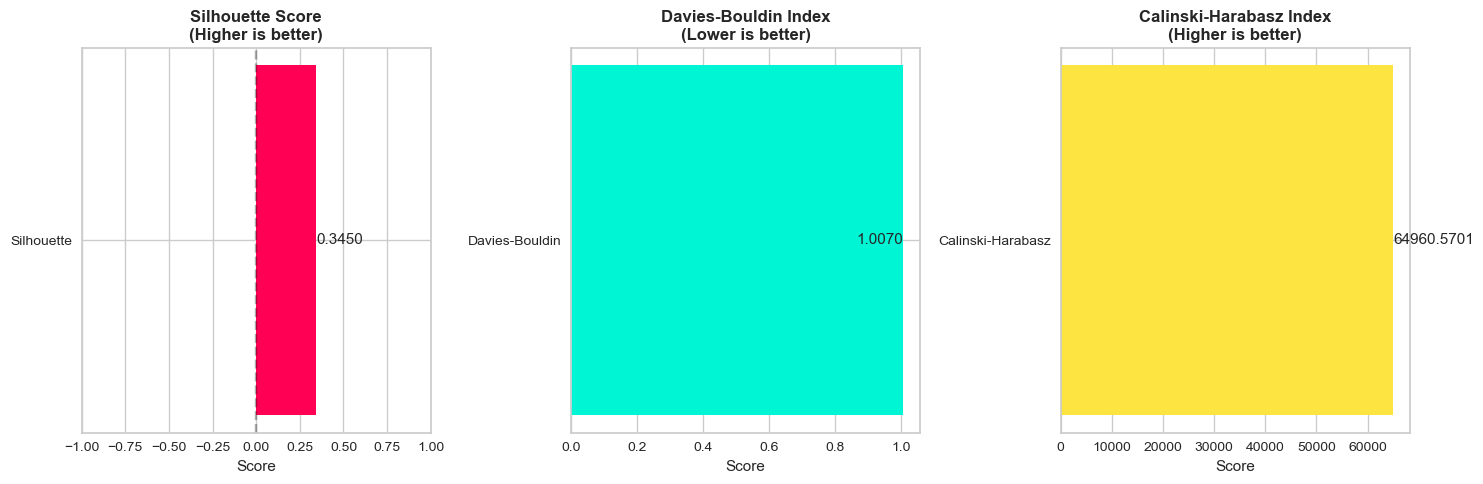

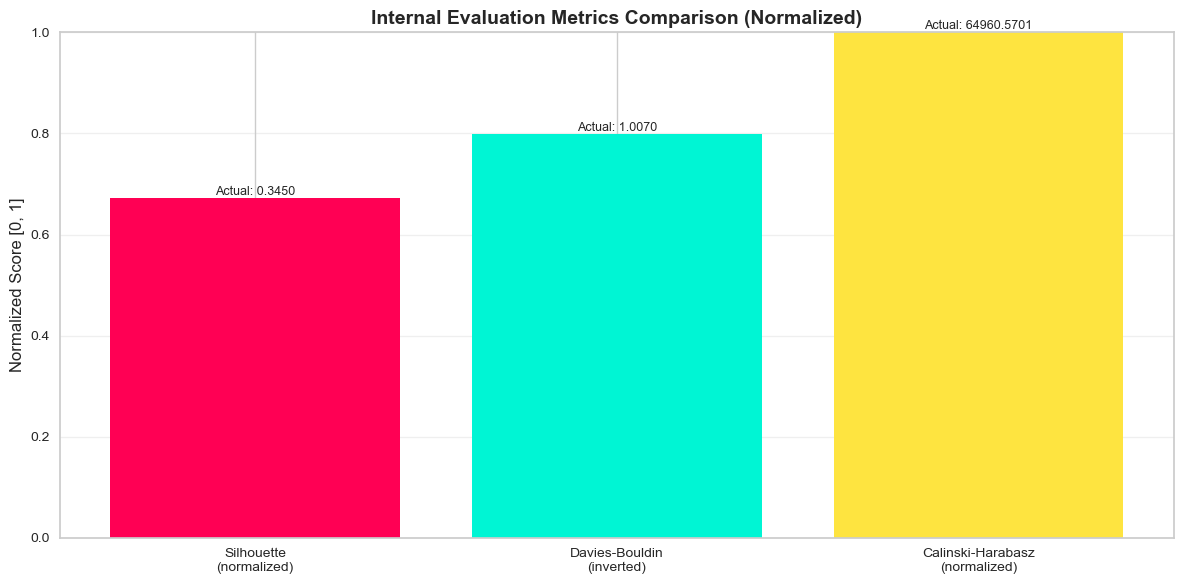

In [15]:
# ============================================================================
# INTERNAL EVALUATION METRICS
# These metrics don't require ground truth labels
# They evaluate clustering quality based on data structure alone
# ============================================================================

print("=" * 70)
print("INTERNAL EVALUATION METRICS")
print("=" * 70)
print()

# Prepare data for internal metrics (use the same PCA data used for clustering)
# Remove 'Cluster' column if it exists in data_pca
pca_features = data_pca.drop('Cluster', axis=1) if 'Cluster' in data_pca.columns else data_pca

# Silhouette Score
# Measures how similar an object is to its own cluster (cohesion) 
# compared to other clusters (separation)
# Range: [-1, 1], where 1 = best, -1 = worst
silhouette = silhouette_score(pca_features, predictions)
print(f"Silhouette Score: {silhouette:.4f}")
print("  → Measures cohesion vs separation")
print("  → Range: [-1, 1], where 1 = best clustering")
print()

# Davies-Bouldin Index
# Measures average similarity ratio of each cluster with its most similar cluster
# Lower values indicate better clustering
davies_bouldin = davies_bouldin_score(pca_features, predictions)
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print("  → Average similarity ratio between clusters")
print("  → Lower is better (closer to 0 = better clustering)")
print()

# Calinski-Harabasz Index (Variance Ratio Criterion)
# Ratio of between-clusters dispersion to within-cluster dispersion
# Higher values indicate better clustering
calinski_harabasz = calinski_harabasz_score(pca_features, predictions)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print("  → Ratio of between-cluster to within-cluster variance")
print("  → Higher is better")
print()

# Summary DataFrame
internal_metrics = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'],
    'Score': [silhouette, davies_bouldin, calinski_harabasz],
    'Interpretation': [
        'Cohesion vs separation (higher is better)',
        'Cluster similarity (lower is better)',
        'Variance ratio (higher is better)'
    ]
})

print("\nSummary of Internal Evaluation Metrics:")
print(internal_metrics.to_string(index=False))
print()

# Visualize internal metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Silhouette Score
axes[0].barh(['Silhouette'], [silhouette], color='#FF0054')
axes[0].set_xlim([-1, 1])
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Score')
axes[0].set_title('Silhouette Score\n(Higher is better)', fontweight='bold')
axes[0].text(silhouette, 0, f'{silhouette:.4f}', 
            va='center', ha='right' if silhouette < 0 else 'left', fontsize=11)

# Davies-Bouldin Index
axes[1].barh(['Davies-Bouldin'], [davies_bouldin], color='#00F5D4')
axes[1].set_xlabel('Score')
axes[1].set_title('Davies-Bouldin Index\n(Lower is better)', fontweight='bold')
axes[1].text(davies_bouldin, 0, f'{davies_bouldin:.4f}', 
            va='center', ha='right', fontsize=11)

# Calinski-Harabasz Index
axes[2].barh(['Calinski-Harabasz'], [calinski_harabasz], color='#FEE440')
axes[2].set_xlabel('Score')
axes[2].set_title('Calinski-Harabasz Index\n(Higher is better)', fontweight='bold')
axes[2].text(calinski_harabasz, 0, f'{calinski_harabasz:.4f}', 
            va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

# Combined comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize scores for comparison (0-1 scale)
# Silhouette: [-1, 1] -> [0, 1]
norm_silhouette = (silhouette + 1) / 2
# Davies-Bouldin: lower is better, so invert (assuming max value of 5)
norm_davies = 1 - min(davies_bouldin / 5, 1)
# Calinski-Harabasz: normalize (assuming max value of 1000)
norm_calinski = min(calinski_harabasz / 1000, 1)

normalized_scores = [norm_silhouette, norm_davies, norm_calinski]
metric_names = ['Silhouette\n(normalized)', 'Davies-Bouldin\n(inverted)', 
                'Calinski-Harabasz\n(normalized)']

bars = ax.bar(metric_names, normalized_scores, 
              color=['#FF0054', '#00F5D4', '#FEE440'])
ax.set_ylabel('Normalized Score [0, 1]', fontsize=12)
ax.set_title('Internal Evaluation Metrics Comparison (Normalized)', 
            fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add actual values as text
for i, (bar, score) in enumerate(zip(bars, [silhouette, davies_bouldin, calinski_harabasz])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'Actual: {score:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

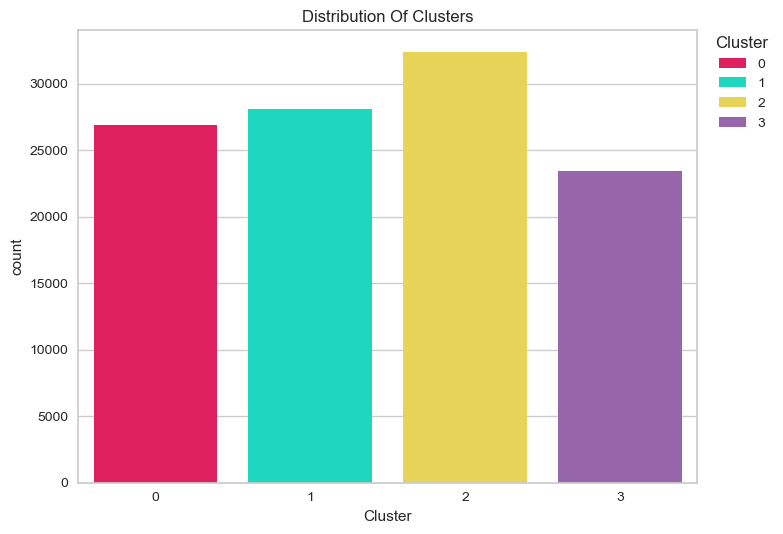

In [16]:

pl = sns.countplot(x='Cluster', data=data, hue='Cluster', palette=colorss)
pl.set_title("Distribution Of Clusters")

plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

In [17]:
cluster = data.groupby(['Cluster']).mean().T
cluster.style.background_gradient(cmap='RdYlGn',axis=1)

Cluster,0,1,2,3
Gender,0.475785,0.496406,0.506129,0.498592
Customer Type,0.406693,0.133808,0.022633,0.128083
Age,37.061423,42.223381,38.657795,42.169468
Type of Travel,0.069575,0.011246,0.927625,0.021418
Class,0.534750,0.118968,0.974589,0.143314
Flight Distance,1104.129956,1664.828505,790.925340,1607.240848
Inflight wifi service,2.321074,2.238434,2.647575,4.302884
Departure/Arrival time convenient,2.776123,1.989039,3.793930,4.312996
Ease of Online booking,2.756617,2.096192,2.661901,4.288591
Gate location,2.956892,2.030996,2.955136,4.213883
